# Quick Start with JAXScape

## Overview

JAXScape makes landscape connectivity analysis fast and differentiable. This quick start demonstrates computing multiple distance metrics from a single source and using automatic differentiation to identify which landscape pixels, if improved, would most increase connectivity—essential for data-driven conservation prioritization.

### Prerequisites:
```bash
pip install jaxscape numpy matplotlib equinox
```

## Setup

Import libraries and configure JAX to use CPU (GPU acceleration is available for larger problems).

In [181]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import equinox as eqx

from jaxscape import GridGraph
from jaxscape import LCPDistance, RSPDistance, ResistanceDistance


## Load Landscape

The **permeability raster** indicates how easily organisms move through each pixel. Higher values = easier movement, lower values = barriers. We add a small constant (0.001) for numerical stability.

In [182]:
# Load permeability raster
permeability = jnp.array(
    np.loadtxt("permeability.csv", delimiter=",")
) + 0.001  # Add small constant for numerical stability

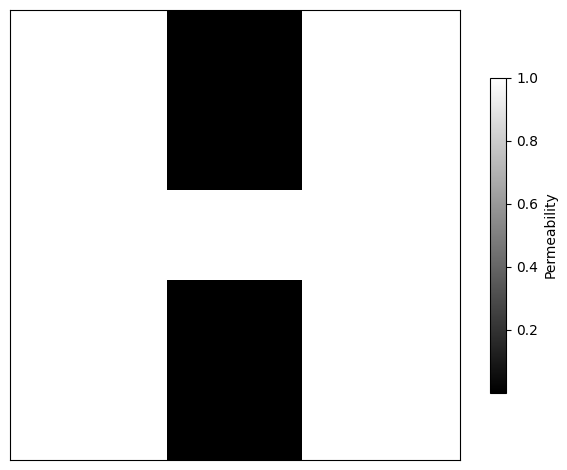

In [183]:
# Visualize the permeability landscape
fig, ax = plt.subplots()
im = ax.imshow(permeability, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)
plt.colorbar(im, ax=ax, label='Permeability', shrink=0.7)
plt.tight_layout()
plt.show()


## Create Landscape Graph

JAXScape converts the raster to a **grid graph** where pixels are nodes and edges connect neighbors with weights from permeability values.

In [184]:
# Construct grid graph from permeability raster
grid = GridGraph(grid=permeability, fun=lambda x, y: (x + y) / 2)

The `fun` parameter defines how to compute edge weights from neighboring pixel values. Here, we use the average of the two pixels, so that our graph is undirected.

## Define Source

Compute distances from the top-left pixel to all other locations.

In [185]:
# Define source location (top-left corner)
source = grid.coord_to_index(jnp.array([0]), jnp.array([0]))

print(f"Source coordinates: (0, 0)")
print(f"Source node index: {source[0]}")

# Convert back to verify
source_coords = grid.index_to_coord(source)
print(f"Verification - coordinates: ({source_coords[0, 0]}, {source_coords[0, 1]})")

Source coordinates: (0, 0)
Source node index: 0
Verification - coordinates: (0, 0)


## Compute Distance Metrics

JAXScape offers three complementary metrics:

**LCP Distance** finds the single optimal route (deterministic movement). **RSP Distance** considers multiple paths weighted by cost, with temperature parameter θ controlling stochasticity. **Resistance Distance** treats the landscape as an electrical network, naturally accounting for all paths (suitable for gene flow).

In [186]:
from jaxscape.solvers import CholmodSolver

# Initialize distance metrics
distances = {
    "LCP Distance": LCPDistance(),
    "RSP Distance": RSPDistance(
        theta=0.01,  # Low temperature → more deterministic
        cost=lambda x: 1 / x  # Cost inversely proportional to permeability
    ),
    "Resistance Distance": ResistanceDistance(solver = CholmodSolver())
}

!!! warning
`ResistanceDistance` relies on a linear solver; you can specify which solver to use with the optional keyword `solver`, with implications both in terms of memory requirements and computational speed. Currently, the best options provided by JAXScape are PyAMG (`PyAMGSolver`) and Cholesky (`CholmodSolver`) solvers. The latter is faster but has a larger memory footprint. To use those, you need to have `pyamg` and `cholespy` installed, respectively. You may install them with the corresponding extra when installing JAXScape:

```console
# Install PyAMG solver (Python 3.10-3.12)
uv add jaxscape --extra pyamg

# Install Cholesky solver (Python 3.10-3.12 only, no wheels for Python 3.13+)
uv add jaxscape --extra cholespy

# Install both solvers
uv add jaxscape --extra solvers
```
> **Note:** These optional solvers are currently not tested in the CI/CD pipeline. Additionally, `cholespy` does not provide wheels for Python 3.13 and above.

If no solver is specified, JAXScape will default to matrix inversion, which is very inefficient for large graphs.

In [187]:
distance_arrays = {}
for name, distance_metric in distances.items():
    print(f"Computing {name}...")
    
    # Compute distances
    dist_to_node = distance_metric(grid, source)
    
    # Convert from node values to 2D array and mask low-permeability areas
    dist_array = grid.node_values_to_array(dist_to_node.ravel())
    dist_array = dist_array * (permeability > 0.1)  # Mask barriers
    
    distance_arrays[name] = dist_array

Computing LCP Distance...
Computing RSP Distance...
Computing Resistance Distance...


### Visualize Distances

Dark regions = close to source (well-connected), bright regions = far (isolated by barriers). Compare how the three metrics differ in their connectivity patterns.

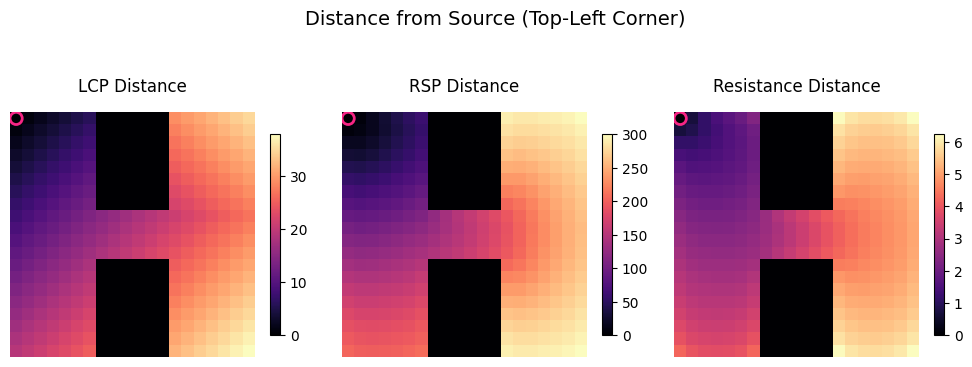

In [188]:
# Visualize all three distance metrics
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for ax, (title, dist_array) in zip(axs, distance_arrays.items()):
    im = ax.imshow(dist_array, cmap='magma')
    ax.set_title(title, fontsize=12, pad=15)
    ax.axis('off')
    
    # Mark source location
    circle = plt.Circle((0, 0), radius=0.5, fill=False, edgecolor='#f72585', linewidth=2)
    ax.add_patch(circle)
  
    
    plt.colorbar(im, ax=ax, shrink=0.6, label='')

fig.suptitle('Distance from Source (Top-Left Corner)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Sensitivity Analysis with Automatic Differentiation

JAXScape can compute **gradients** of connectivity metrics with respect to landscape properties. We'll calculate how changing each pixel's permeability affects **average path length (APL)**—the mean distance between all node pairs. The gradient `∂APL/∂permeability` identifies connectivity bottlenecks: pixels with large negative gradients are high-priority restoration targets.

In [189]:
@eqx.filter_jit
def average_path_length(permeability, distance_metric):
    """Compute average path length across all node pairs.
    
    This is a global connectivity measure: lower values indicate
    better overall connectivity.
    """
    grid = GridGraph(permeability)
    dist = distance_metric(grid)
    return dist.sum() / grid.nv**2

# Create gradient function
grad_connectivity = jax.grad(average_path_length)

In [190]:
# Compute sensitivity (gradient)
print("Computing gradient via automatic differentiation...")

sensitivities = grad_connectivity(permeability, LCPDistance())


Computing gradient via automatic differentiation...


### Visualize Sensitivity

Darker regions = connectivity bottlenecks with high restoration priority. Lighter regions = minimal impact on overall connectivity.

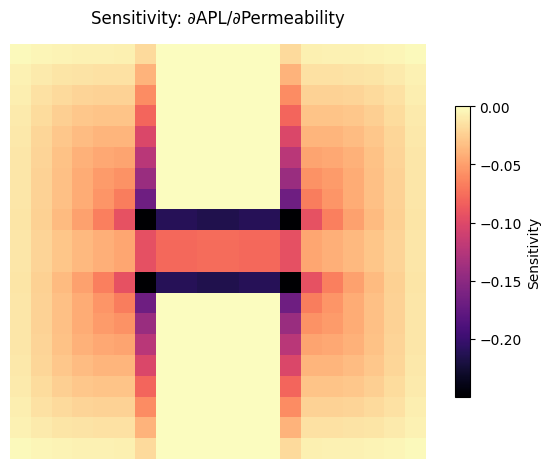

In [191]:
# Mask barriers for visualization
sensitivities_masked = sensitivities * (permeability > 0.1)

fig, ax = plt.subplots()

# Sensitivity map
im = ax.imshow(sensitivities_masked, cmap='magma')
ax.set_title('Sensitivity: ∂APL/∂Permeability', fontsize=12, pad=15)
ax.axis('off')

plt.colorbar(im, ax=ax, shrink=0.7, label='Sensitivity')
plt.tight_layout()


## Key Takeaways

You've learned JAXScape's core workflow: constructing grid graphs from rasters, computing distance metrics (LCP, RSP, Resistance), and using automatic differentiation for sensitivity analysis. The gradient-based approach identifies connectivity bottlenecks for data-driven conservation prioritization.